This notebook tries to extend the results from the adversarial spheres paper: https://arxiv.org/pdf/1801.02774.pdf

In particular, instead of generating from spheres, we generate from Gaussians
(with the hope that the high dimensionality makes them effectively spheres).

This is an iteration on top of gaussian-v1.ipynb.
Unlike the first notebook,
we focus on the norm $O(1)$ regime in this notebook,
since this is where the vanilla NN performs the best.
The plan is to also study the NTK of this vanilla NN in the future.

Greg Yang's framework can also compute NTK even with batchnorm?

We also provide visualizations of what the network is doing at different radii.

### Import dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from art.data_generators import TensorFlowV2DataGenerator
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import ProjectedGradientDescent
from art.defences.trainer import AdversarialTrainer

tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Data generation utils

In [2]:
def generate_normal_data(dim, s0, s1, num_samples):
    assert num_samples % 2 == 0
    assert s0 <= s1
    
    ys = np.concatenate([
        np.zeros(shape=num_samples // 2, dtype=np.int64),
        np.ones(shape=num_samples // 2, dtype=np.int64)
    ])
    
    xs = np.concatenate([
        np.random.normal(scale=s0, size=(num_samples // 2, dim)),
        np.random.normal(scale=s1, size=(num_samples // 2, dim))
    ])
    
    perm = np.random.permutation(num_samples)
    xs = xs[perm]
    ys = ys[perm]
    
    return xs, ys

def normalize(xs: np.ndarray, norm):
    norm_xs = xs / np.linalg.norm(xs, axis=-1, ord=norm).reshape(-1, 1)
    return norm_xs

def radial_attack(
    xs: np.ndarray, ys: np.ndarray,
    attack_norm, attack_eps,
):
    norm_xs = normalize(xs, norm=attack_norm)
    
    adv_xs = xs.copy()
    adv_xs[ys == 0] += attack_eps * norm_xs[ys == 0]
    adv_xs[ys == 1] -= attack_eps * norm_xs[ys == 1]
    
    return adv_xs

xs, ys = generate_normal_data(dim=2, s0=0.3, s1=0.7, num_samples=4)
radial_attack(xs=xs, ys=ys, attack_norm=2, attack_eps=0.1)

array([[-0.47673766, -0.56789626],
       [-0.00652595, -0.7254997 ],
       [-0.22993774, -0.42023972],
       [ 0.00176443,  0.39197192]])

### Experiment setup

In [3]:
def run_experiment_v2(
    dim, s0, s1,
    num_train,
    model_layers,
    train_epochs,
    attack_norm,
    attack_eps,
    attack_eps_step,
    attack_iters,
    train_batch_size=64,
    attack_batch_size=256,
    num_test=4096,
    seed=42,
    adv_train=False,
):
    """
    Default values for num_train and num_test are size of CIFAR10 dataset.
    
    Keras code derived from https://keras.io/examples/vision/mnist_convnet/.
    
    ART code derived from https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/adversarial_retraining.ipynb
    and https://github.com/Trusted-AI/adversarial-robustness-toolbox/issues/238.
    """
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    x_train, y_train = generate_normal_data(
        dim=dim, s0=s0, s1=s1,
        num_samples=num_train,
    )

    x_test, y_test = generate_normal_data(
        dim=dim, s0=s0, s1=s1,
        num_samples=num_test,
    )
    
    model = keras.Sequential(
        [keras.Input(shape=x_train[0].shape)]
        + model_layers
    )
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer="adam",
        metrics=["accuracy"]
    )
    
    # Wrapper around https://github.com/tensorflow/tensorflow/blob/85c8b2a817f95a3e979ecd1ed95bff1dc1335cff/tensorflow/python/keras/engine/training.py#L724
    def train_step(model, images, labels):
        model.train_step((images, labels))
    
    art_model = TensorFlowV2Classifier(
        model=model,
        input_shape=x_test[0].shape,
        nb_classes=2,
        clip_values=None, #[-x_test.max(), x_test.max()],
        loss_object=model.loss,
        train_step=train_step,
    )
    art_pgd_attack = ProjectedGradientDescent(
        art_model,
        norm=attack_norm,
        eps=attack_eps,
        eps_step=attack_eps_step,
        max_iter=attack_iters,
        batch_size=attack_batch_size,
    )
    
    if adv_train:
        adv_trainer = AdversarialTrainer(art_model, attacks=art_pgd_attack, ratio=1.0)
        adv_trainer.fit(x=x_train, y=y_train, batch_size=train_batch_size, nb_epochs=train_epochs)
        # TODO: Add way to monitor adv. acc
    else:
        model.fit(
            x_train,
            y_train,
            batch_size=train_batch_size,
            epochs=train_epochs,
            validation_data=(x_test, y_test),
            verbose=2,
        )

    model.trainable = False
    
    art_model = TensorFlowV2Classifier(
        model=model,
        input_shape=x_test[0].shape,
        nb_classes=2,
        loss_object=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        clip_values=None, #[-x_test.max(), x_test.max()],
    )
    
    x_train_adv_pgd = art_pgd_attack.generate(x_train[:num_test], y=y_train[:num_test])    
    x_test_adv_pgd = art_pgd_attack.generate(x_test, y=y_test)
    
    x_train_adv_rad = radial_attack(xs=x_train[:num_test], ys=y_train[:num_test],
                                    attack_norm=attack_norm, attack_eps=attack_eps)
    x_test_adv_rad = radial_attack(xs=x_test, ys=y_test,
                                   attack_norm=attack_norm, attack_eps=attack_eps)
    
    _, nat_train_acc = model.evaluate(x_train, y_train, verbose=0)
    _, nat_test_acc = model.evaluate(x_test, y_test, verbose=0)
    _, adv_pgd_train_acc = model.evaluate(x_train_adv_pgd, y_train[:num_test], verbose=0)
    _, adv_pgd_test_acc = model.evaluate(x_test_adv_pgd, y_test, verbose=0)
    _, adv_rad_train_acc = model.evaluate(x_train_adv_rad, y_train[:num_test], verbose=0)
    _, adv_rad_test_acc = model.evaluate(x_test_adv_rad, y_test, verbose=0)
    
    print("Nat train acc     :", nat_train_acc)
    print("Nat test  acc     :", nat_test_acc)
    print("Adv-pgd train acc :", adv_pgd_train_acc)
    print("Adv-pgd test  acc :", adv_pgd_test_acc)
    print("Adv-rad train acc :", adv_rad_train_acc)
    print("Adv-rad test  acc :", adv_rad_test_acc)
    
    return dict(
        model=model,
        train_data=(x_train, y_train),
        test_data=(x_test, y_test),
        x_train_adv_pgd=x_train_adv_pgd,
        x_test_adv_pgd=x_test_adv_pgd,
        x_train_adv_rad=x_train_adv_rad,
        x_test_adv_rad=x_test_adv_rad,
    )

In [4]:
def cls1_frac_by_rad(
    model: tf.keras.Model,
    rads: np.ndarray,
    num_samples_per_rad=256,
    batch_size=64,
    
):
    dim = model.input_shape[-1]
    
    cls1_fracs = np.zeros_like(rads)
    for idx, r in enumerate(tqdm(rads)):
        xs = r * normalize(
            xs=np.random.normal(size=(num_samples_per_rad, dim)),
            norm=2
        )

        pred_probs = model.predict(xs, batch_size=batch_size)
        preds = np.argmax(pred_probs, axis=-1)
        
        cls1_fracs[idx] = (preds == 1).mean()
        
    return cls1_fracs

### Run experiments

Norm $O(1)$, standard training

In [5]:
%%time
D = 1000
res = run_experiment_v2(
    dim=D, s0=1.0 / np.sqrt(D), s1=1.3 / np.sqrt(D),
    num_train=10 ** 4,
    model_layers=[
        layers.Dense(1000, activation="relu"),
        layers.Dense(1000, activation="relu"),
        layers.Dense(2),
    ],
    train_batch_size=128,
    train_epochs=10,
    attack_norm=2,
    attack_eps=0.1,
    attack_eps_step=0.01,
    attack_iters=20,
)

Epoch 1/10
79/79 - 2s - loss: 0.4559 - accuracy: 0.7742 - val_loss: 0.1624 - val_accuracy: 0.9573
Epoch 2/10
79/79 - 0s - loss: 0.0225 - accuracy: 0.9956 - val_loss: 0.1221 - val_accuracy: 0.9512
Epoch 3/10
79/79 - 0s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0662 - val_accuracy: 0.9778
Epoch 4/10
79/79 - 0s - loss: 5.2039e-04 - accuracy: 1.0000 - val_loss: 0.0663 - val_accuracy: 0.9775
Epoch 5/10
79/79 - 0s - loss: 2.9381e-04 - accuracy: 1.0000 - val_loss: 0.0693 - val_accuracy: 0.9753
Epoch 6/10
79/79 - 0s - loss: 2.0487e-04 - accuracy: 1.0000 - val_loss: 0.0661 - val_accuracy: 0.9766
Epoch 7/10
79/79 - 0s - loss: 1.5302e-04 - accuracy: 1.0000 - val_loss: 0.0669 - val_accuracy: 0.9741
Epoch 8/10
79/79 - 0s - loss: 1.1928e-04 - accuracy: 1.0000 - val_loss: 0.0672 - val_accuracy: 0.9746
Epoch 9/10
79/79 - 0s - loss: 9.5666e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9751
Epoch 10/10
79/79 - 0s - loss: 7.8464e-05 - accuracy: 1.0000 - val_loss: 0.0667 - val_accuracy

PGD - Batches: 0it [00:00, ?it/s]

PGD - Batches: 0it [00:00, ?it/s]

Nat train acc     : 1.0
Nat test  acc     : 0.97412109375
Adv-pgd train acc : 0.6533203125
Adv-pgd test  acc : 0.1005859375
Adv-rad train acc : 1.0
Adv-rad test  acc : 0.75732421875
Wall time: 8.91 s


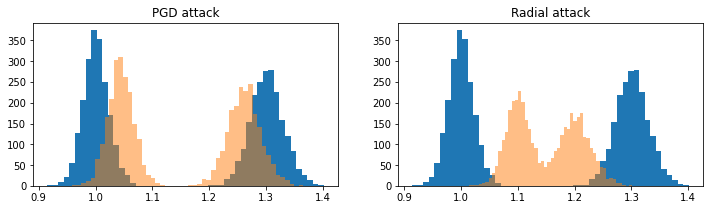

In [6]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50, label="x_test");
plt.hist(np.linalg.norm(res["x_test_adv_pgd"], ord=2, axis=-1), bins=50, label="x_test_adv", alpha=0.5);
plt.title(f"PGD attack");

plt.subplot(1, 2, 2)
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50, label="x_test");
plt.hist(np.linalg.norm(res["x_test_adv_rad"], ord=2, axis=-1), bins=50, label="x_test_adv", alpha=0.5);
plt.title(f"Radial attack");

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

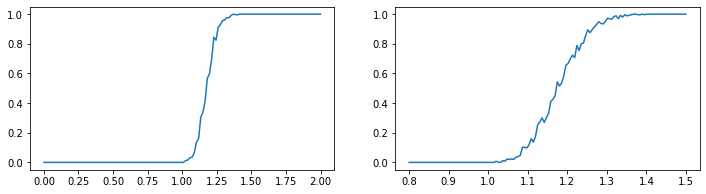

In [7]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
rads = np.linspace(start=0, stop=2, num=128)
cls1_fracs = cls1_frac_by_rad(model=res["model"], rads=rads)
plt.plot(rads, cls1_fracs);

plt.subplot(1, 2, 2)
rads = np.linspace(start=0.8, stop=1.5, num=128)
cls1_fracs = cls1_frac_by_rad(model=res["model"], rads=rads)
plt.plot(rads, cls1_fracs);

---

Norm $O(1)$, adversarial training

In [11]:
%%time
D = 1000
res = run_experiment_v2(
    dim=D, s0=1.0 / np.sqrt(D), s1=1.3 / np.sqrt(D),
    num_train=10 ** 4,
    model_layers=[
        layers.Dense(1000, activation="relu"),
        layers.Dense(1000, activation="relu"),
        layers.Dense(2),
    ],
    train_batch_size=256,
    train_epochs=10,
    attack_norm=2,
    attack_eps=0.1,
    attack_eps_step=0.01,
    attack_iters=20,
    adv_train=True,
)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Nat train acc     : 1.0
Nat test  acc     : 0.9921875
Adv-pgd train acc : 1.0
Adv-pgd test  acc : 0.35205078125
Adv-rad train acc : 1.0
Adv-rad test  acc : 0.736083984375
Wall time: 1min 34s


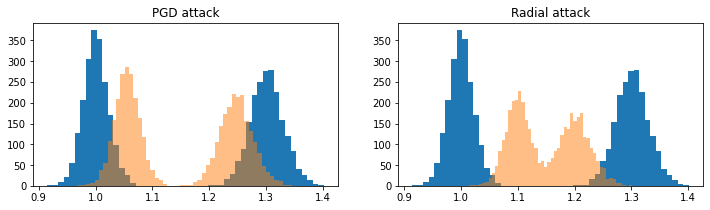

In [12]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50, label="x_test");
plt.hist(np.linalg.norm(res["x_test_adv_pgd"], ord=2, axis=-1), bins=50, label="x_test_adv", alpha=0.5);
plt.title(f"PGD attack");

plt.subplot(1, 2, 2)
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50, label="x_test");
plt.hist(np.linalg.norm(res["x_test_adv_rad"], ord=2, axis=-1), bins=50, label="x_test_adv", alpha=0.5);
plt.title(f"Radial attack");

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

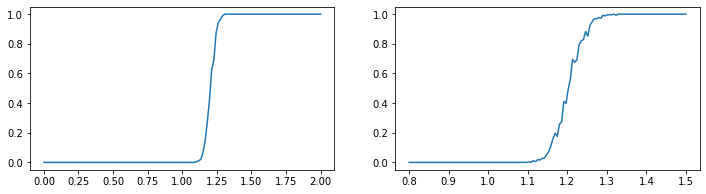

In [13]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
rads = np.linspace(start=0, stop=2, num=128)
cls1_fracs = cls1_frac_by_rad(model=res["model"], rads=rads)
plt.plot(rads, cls1_fracs);

plt.subplot(1, 2, 2)
rads = np.linspace(start=0.8, stop=1.5, num=128)
cls1_fracs = cls1_frac_by_rad(model=res["model"], rads=rads)
plt.plot(rads, cls1_fracs);

---

### Summary and conclusions
Overall we get pretty similar behavior in the spherical and Gaussian cases (see sphere-v1.ipynb).

Like in the spherical case,
the vanilla feed-forward NN does worse on norm-$O(\sqrt{D})$ data than norm-$O(1)$ data
(93% test acc vs 99% test acc).
However, this difference can be mitigated with a batchnorm layer.